* https://www.gov.uk/guidance/mot-inspection-manual-for-private-passenger-and-light-commercial-vehicles
* https://www.data.gov.uk/dataset/e3939ef8-30c7-4ca8-9c7c-ad9475cc9b2f/anonymised-mot-tests-and-results
* https://www.gov.uk/government/news/mot-changes-20-may-2018

#### Data separator cleanup code

In [1]:
from dask.distributed import Client, wait
from distributed import progress
from glob import glob
from operator import itemgetter
import dask.dataframe as dd
import csv
import pandas as pd

In [2]:
import dask
dask.__version__

'2023.11.0'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 62.52 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45119,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 62.52 GiB
Comm: tcp://127.0.0.1:35699,Total threads: 4
Dashboard: http://127.0.0.1:37483/status,Memory: 15.63 GiB
Nanny: tcp://127.0.0.1:34883,


In [4]:
txt_files = glob('data/test_*.txt')
csv_files = glob('data/unzipped/**/*.csv', recursive=True)

files = txt_files + csv_files
len(files)

24

In [5]:
def sniff_dialect(file):
    with open(file) as csvfile:
        dialect = csv.Sniffer().sniff(csvfile.read(10000))
        dialect_info = dict(dialect.__dict__)
        dialect_info['file'] = file
    return dialect_info

In [6]:
dialects = [sniff_dialect(file) for file in files]

csv_info_df = (
    pd.DataFrame(dialects)
    .drop(columns=['__module__', '_name', '__doc__'])
    .set_index('file')
    .sort_index()
    .reset_index()
)

csv_info_df

,file,lineterminator,quoting,doublequote,delimiter,quotechar,skipinitialspace
0,data/test_item_2005.txt,\r\n,0,False,|,"""",False
1,data/test_item_2006.txt,\r\n,0,False,|,"""",False
2,data/test_item_2007.txt,\r\n,0,False,|,"""",False
3,data/test_item_2008.txt,\r\n,0,False,|,"""",False
4,data/test_item_2009.txt,\r\n,0,False,|,"""",False
5,data/test_item_2010.txt,\r\n,0,False,|,"""",False
6,data/test_item_2011.txt,\r\n,0,False,|,"""",False
7,data/test_item_2012.txt,\r\n,0,False,|,"""",False
8,data/test_item_2013.txt,\r\n,0,False,|,"""",False
9,data/test_item_2014.txt,\r\n,0,False,|,"""",False


In [7]:
csv_info_df.lineterminator.describe()

count       24
unique       1
top       \r\n
freq        24
Name: lineterminator, dtype: object

In [8]:
csv_info_df.skipinitialspace.describe()

count        24
unique        1
top       False
freq         24
Name: skipinitialspace, dtype: object

In [9]:
csv_info_df.delimiter.unique()

array(['|'], dtype=object)

In [10]:
results_files_df = csv_info_df[csv_info_df.file.str.contains('result')]
results_files_df

,file,lineterminator,quoting,doublequote,delimiter,quotechar,skipinitialspace
12,data/test_result_2005.txt,\r\n,0,False,|,"""",False
13,data/test_result_2006.txt,\r\n,0,False,|,"""",False
14,data/test_result_2007.txt,\r\n,0,False,|,"""",False
15,data/test_result_2008.txt,\r\n,0,False,|,"""",False
16,data/test_result_2009.txt,\r\n,0,False,|,"""",False
17,data/test_result_2010.txt,\r\n,0,False,|,"""",False
18,data/test_result_2011.txt,\r\n,0,False,|,"""",False
19,data/test_result_2012.txt,\r\n,0,False,|,"""",False
20,data/test_result_2013.txt,\r\n,0,False,|,"""",False
21,data/test_result_2014.txt,\r\n,0,False,|,"""",False


## Results

In [11]:
def read_results(file, sep):
    df = dd.read_csv(file,
                     delimiter=sep,
                     doublequote=False,
                     on_bad_lines='warn',
                     #include_path_column=True, # DISABLED as Polars doesn't like the resulting categorical column
                     #parse_dates=['test_date'], # DISABLED as causes datetime to be numpy dtypes
                     dtype_backend='pyarrow',
                     # engine='pyarrow',
                    )
    return df

def parse_dates_pd(df):
    df['test_date'] = pd.to_datetime(df['test_date'], format='ISO8601', errors='coerce')
    df['first_use_date'] = pd.to_datetime(df['first_use_date'], format='ISO8601', errors='coerce')
    return df

def parse_dates_dd(df):
    df['test_date'] = dd.to_datetime(df['test_date'], format='ISO8601',
                                     # utc=True,
                                     errors='coerce')
    df['first_use_date'] = dd.to_datetime(df['first_use_date'], format='ISO8601',
                                          # utc=True,
                                          errors='coerce')
    return df

def make_dtypes_pyarrow(df):
    return df.convert_dtypes(dtype_backend='pyarrow')

In [12]:
result_records = results_files_df[['file', 'delimiter']].to_records(index=False)
ddfs = [read_results(file, sep) for file, sep in result_records]

In [13]:
ddf = (
    dd.concat(ddfs[:])
    #.map_partitions(parse_dates_pd) # pandas version
    .pipe(parse_dates_dd) # dask version
    #.map_partitions(make_dtypes_pyarrow) # requires pandas, can't be done with dask
    .astype({'test_date': 'timestamp[us][pyarrow]', 'first_use_date': 'timestamp[us][pyarrow]'})
)

In [14]:
ddf.dtypes

test_id                      int64[pyarrow]
vehicle_id                   int64[pyarrow]
test_date            timestamp[us][pyarrow]
test_class_id                int64[pyarrow]
test_type                   string[pyarrow]
test_result                 string[pyarrow]
test_mileage                 int64[pyarrow]
postcode_area               string[pyarrow]
make                        string[pyarrow]
model                       string[pyarrow]
colour                      string[pyarrow]
fuel_type                   string[pyarrow]
cylinder_capacity            int64[pyarrow]
first_use_date       timestamp[us][pyarrow]
dtype: object

In [15]:
f_result = (
    ddf
    .partitions[:]
    .to_parquet('test_result.parquet', write_index=False, overwrite=True, compute=False)
    .persist()
)
progress(f_result)

VBox()

Skipping line 46202: expected 14 fields, saw 16

Skipping line 86979: expected 14 fields, saw 16

Skipping line 361415: expected 14 fields, saw 16

Skipping line 566945: expected 14 fields, saw 16

Skipping line 281444: expected 14 fields, saw 16

Skipping line 115394: expected 14 fields, saw 16



### Roundtrip

In [16]:
wait(f_result)

ddf_result = dd.read_parquet('test_result.parquet', 
                             # dtype_backend="pyarrow", # causes dates to be read as timestamp[us] rather than timestamp[ns]
                             # use_nullable_dtypes=True, # deprecated
                            )

In [17]:
# Note the differing dtypes
# ddf_result.info(verbose=True)
ddf_result.dtypes

test_id                      int64[pyarrow]
vehicle_id                   int64[pyarrow]
test_date            timestamp[us][pyarrow]
test_class_id                int64[pyarrow]
test_type                   string[pyarrow]
test_result                 string[pyarrow]
test_mileage                 int64[pyarrow]
postcode_area               string[pyarrow]
make                        string[pyarrow]
model                       string[pyarrow]
colour                      string[pyarrow]
fuel_type                   string[pyarrow]
cylinder_capacity            int64[pyarrow]
first_use_date       timestamp[us][pyarrow]
dtype: object

In [18]:
ddf_result.head()

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
0,804664368,256274986,2005-01-01 00:00:00,0,NT,P,23459,TF,FORD,UNCLASSIFIED,SILVER,PE,<NA>,<NA>
1,392603376,633988704,2005-01-01 00:00:00,0,NT,P,40961,E,LOTUS,UNCLASSIFIED,RED,PE,<NA>,<NA>
2,1894843206,1320781748,2005-01-01 00:00:00,0,NT,P,16416,S,VAUXHALL,UNCLASSIFIED,BLUE,PE,<NA>,<NA>
3,830908928,1263031090,2005-01-01 00:00:00,4,NT,P,93318,W,LAND ROVER,109 V8 S.W.,BLUE,PE,3528,1981-04-06 00:00:00
4,727535460,1123257842,2005-01-01 00:00:00,4,NT,P,121930,RG,CITROEN,AX,WHITE,DI,1360,1993-08-31 00:00:00


In [19]:
ddf_result.npartitions

538

In [20]:
rover_df = ddf_result.query('vehicle_id == 1238787680').compute()

In [21]:
rover_df

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
619621,523600018,1238787680,2005-07-29 00:00:00,4,NT,P,62931,CV,ROVER,200,RED,PE,1796,1997-09-08 00:00:00
75461,566248504,1238787680,2006-08-11 00:00:00,4,NT,P,73606,CH,ROVER,200,RED,PE,1796,1997-09-08 00:00:00
738312,608896990,1238787680,2007-07-13 00:00:00,4,NT,P,83496,CH,ROVER,200,RED,PE,1796,1997-09-08 00:00:00
96799,651545476,1238787680,2008-07-17 00:00:00,4,NT,P,96680,CH,ROVER,200,RED,PE,1796,1997-09-08 00:00:00
163440,694193962,1238787680,2009-07-22 00:00:00,4,NT,F,103333,NG,ROVER,200,RED,PE,1796,1997-09-08 00:00:00
594408,736842448,1238787680,2009-08-03 00:00:00,4,RT,P,103575,NG,ROVER,200,RED,PE,1796,1997-09-08 00:00:00
72562,779490934,1238787680,2010-07-15 00:00:00,4,NT,P,115188,LU,ROVER,200,RED,PE,1796,1997-09-08 00:00:00
50693,822139420,1238787680,2011-07-11 00:00:00,4,NT,P,126169,LU,ROVER,200,RED,PE,1796,1997-09-08 00:00:00
562174,864787906,1238787680,2012-07-17 00:00:00,4,NT,F,205404,LU,ROVER,200,RED,PE,1796,1997-09-08 00:00:00
282107,907436392,1238787680,2012-07-20 00:00:00,4,RT,P,138108,LU,ROVER,200,RED,PE,1796,1997-09-08 00:00:00


<Axes: xlabel='test_date'>

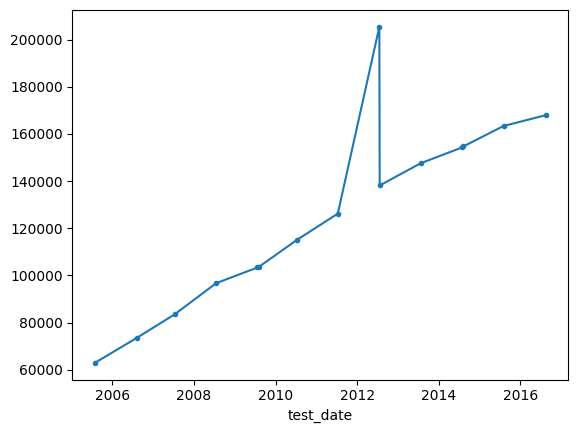

In [22]:
rover_df.set_index('test_date').test_mileage.plot(marker='.')

## Items

In [23]:
item_files_df = csv_info_df[csv_info_df.file.str.contains('item')]
item_files_df

,file,lineterminator,quoting,doublequote,delimiter,quotechar,skipinitialspace
0,data/test_item_2005.txt,\r\n,0,False,|,"""",False
1,data/test_item_2006.txt,\r\n,0,False,|,"""",False
2,data/test_item_2007.txt,\r\n,0,False,|,"""",False
3,data/test_item_2008.txt,\r\n,0,False,|,"""",False
4,data/test_item_2009.txt,\r\n,0,False,|,"""",False
5,data/test_item_2010.txt,\r\n,0,False,|,"""",False
6,data/test_item_2011.txt,\r\n,0,False,|,"""",False
7,data/test_item_2012.txt,\r\n,0,False,|,"""",False
8,data/test_item_2013.txt,\r\n,0,False,|,"""",False
9,data/test_item_2014.txt,\r\n,0,False,|,"""",False


In [24]:
def read_items(file, sep):
    df = dd.read_csv(file,
                     delimiter=sep,
                     dtype={'dangerous_mark': 'string[pyarrow]'},
                     dtype_backend='pyarrow',
                     # engine='pyarrow',
                    )
        
    return df

item_records = item_files_df[['file', 'delimiter']].to_records(index=False)
item_ddfs = [read_items(file, sep) for file, sep in item_records]

In [25]:
item_ddf = dd.concat(item_ddfs[:])

In [26]:
item_ddf.dtypes

test_id            int64[pyarrow]
rfr_id             int64[pyarrow]
rfr_type_code     string[pyarrow]
location_id        int64[pyarrow]
dangerous_mark    string[pyarrow]
dtype: object

In [27]:
item_ddf.info()
item_ddf.head()

<class 'dask.dataframe.core.DataFrame'>
Columns: 5 entries, test_id to dangerous_mark
dtypes: int64[pyarrow](3), string[pyarrow](1), string(1)

,test_id,rfr_id,rfr_type_code,location_id,dangerous_mark
0,1343771031,8394,A,7,<NA>
1,1560692612,8394,F,13,<NA>
2,1560692612,7977,F,9,<NA>
3,1560692612,7916,A,7,<NA>
4,1560692612,7916,A,9,<NA>


In [28]:
f_item = (
    item_ddf
    .to_parquet('item.parquet', write_index=False, overwrite=True, compute=False)
    .persist()
)

progress(f_item)

VBox()

In [29]:
wait(f_item)
item_ddf = dd.read_parquet('item.parquet')

In [30]:
item_ddf.dtypes

test_id            int64[pyarrow]
rfr_id             int64[pyarrow]
rfr_type_code     string[pyarrow]
location_id        int64[pyarrow]
dangerous_mark    string[pyarrow]
dtype: object

In [31]:
rfr_counts = item_ddf.rfr_id.value_counts().compute()

In [32]:
rfr_counts

rfr_id
8394    95917179
8141    40438866
8293    31317722
8310    24931131
8483    16920867
          ...   
9296           1
9359           1
9388           1
9392           1
9394           1
Name: count, Length: 4450, dtype: int64[pyarrow]

## Reasons for rejection (test fail)

Not sure if this includes advisories

In [33]:
rfr_df = dd.read_csv('data/unzipped/dft_item_detail.csv', sep='|', dtype_backend='pyarrow')
rfr_df.info(verbose=True)
rfr_df.head()

FileNotFoundError: An error occurred while calling the read_csv method registered to the pandas backend.
Original Message: [Errno 2] No such file or directory: '/home/ian/workspace/personal/mot_pandas2_polars_dask/data/unzipped/dft_item_detail.csv'

In [ ]:
rfr_df.query('rfr_id == 8394').compute()